# Micro-narrative analysis of _The Lord of the Rings_

In [1]:
import glob
import os.path

import pandas as pd

docs = []
for file in glob.glob("input/*.txt"):
    with open(file) as f:
        text = f.read()
        sections = text.split("\n")
        for section in sections:
            section = section.strip()
            if section:
                docs.append(section)

In [2]:
from narrativegraphs import CooccurrenceGraph

if os.path.exists("lotr.db"):
    model = CooccurrenceGraph.load("lotr.db")
else:
    model = CooccurrenceGraph(
        sqlite_db_path="lotr.db",
        on_existing_db="overwrite",
        n_cpu=1
    ).fit(docs)

In [3]:
# here, we can interactively inspect the co-occurrence graph
# model.serve_visualizer()

## The distribution of entities

Below, we will look at the distribution of extracted entities. We expect, as for single-word distributions, to be in the Large Number of Rare Events (LNRE) zone where we see a long tail of distinct, rare entities. The number of distinct entities (our vocabulary) grows with the size of the corpus. Additionally, according to Zipf's law, we should see that the most frequent entities make up a considerable portion of the total number of entity occurrences.

We will look at both unresolved entity mentions and resolved entity mentions, but onwards we will use the resolved entities.

In [7]:
from sharedutils import fit_and_visualize_entity_frequencies

unresolved_ents_df = model.entity_mentions_.groupby("entity_span_text").size().reset_index(name="frequency")
resolved_ents_df = model.entities_

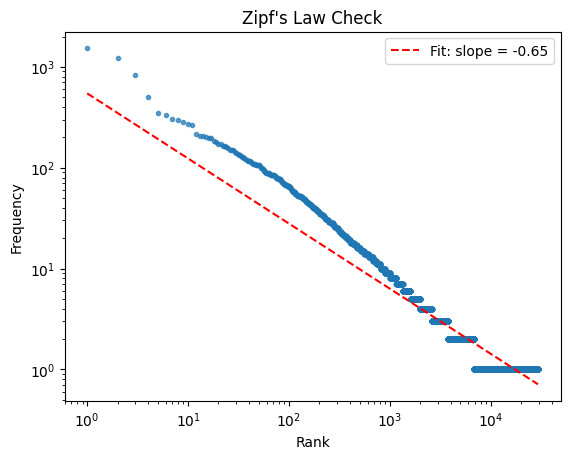

In [8]:
fit_and_visualize_entity_frequencies(unresolved_ents_df)

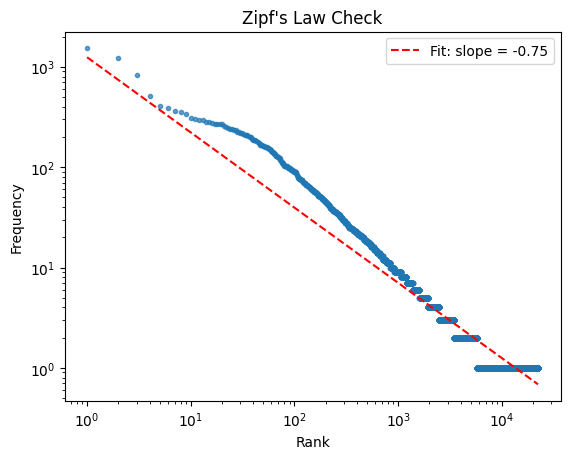

In [9]:
fit_and_visualize_entity_frequencies(resolved_ents_df)

Both roughly fit a Zipfian distribituion. The resolved entities have a slightly steeper slope as "the rich get richer" by adding lower frequency counts of some entities to other entities. Hence, the ranked list becomes shorter, but the total number of entity occurrences are the same.

In thi

In [3]:
model.cooccurrences_

,id,entity_one,entity_one_frequency,entity_two,entity_two_frequency,frequency,doc_frequency,spread,adjusted_tf_idf,pmi,entity_one_id,entity_two_id
0,1,the Three Rings,36,Elven,340,1,1,0.000108,0.0,1.833991,1,2
1,2,the Three Rings,36,the sky,1494,1,1,0.000108,0.0,1.191120,1,3
2,3,Elven,340,the sky,1494,2,2,0.000216,3080.0,0.516973,2,3
3,4,Dwarf,771,their halls,19,2,2,0.000216,3080.0,2.056995,4,5
4,5,the Dark Lord,654,his dark throne,2,2,2,0.000216,3080.0,3.106195,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...
324051,324052,Rose,93,Little Elanor,18,1,1,0.000108,0.0,2.698017,10104,21110
324052,324053,his lap,100,Rose,93,1,1,0.000108,0.0,1.953290,9999,10104
324053,324054,his chair,245,Little Elanor,18,1,1,0.000108,0.0,2.277334,2481,21110
324054,324055,his chair,245,his lap,100,1,1,0.000108,0.0,1.532607,2481,9999


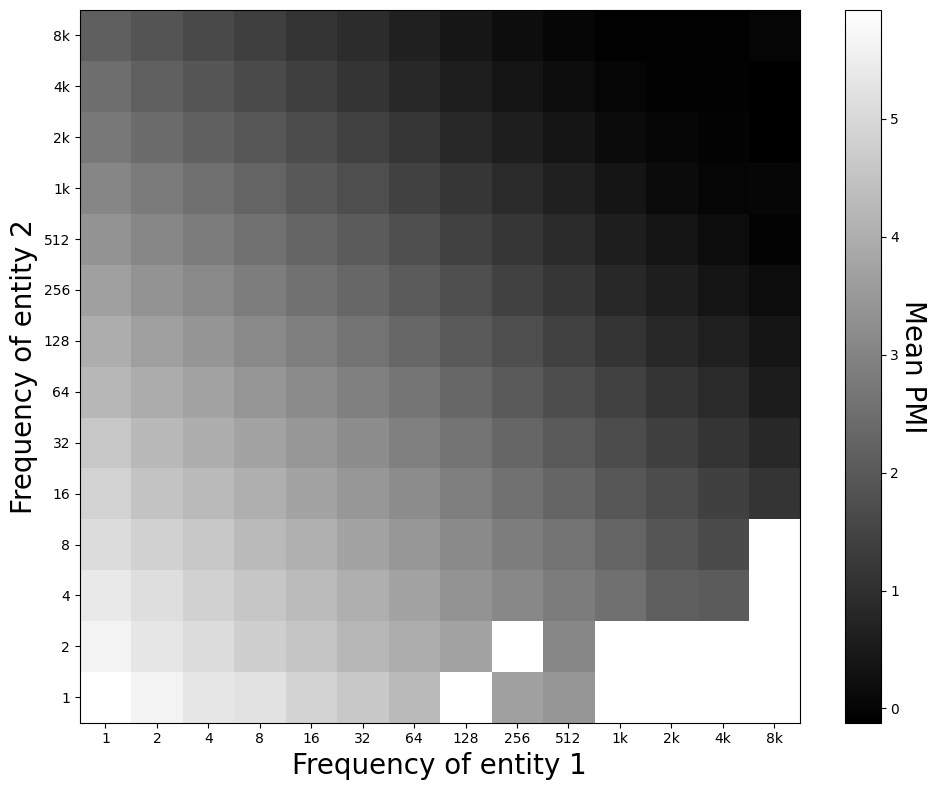

In [6]:
from sharedutils import visualize_pmi_by_frequency

visualize_pmi_by_frequency(model.cooccurrences_)

In [18]:
from narrativegraphs import GraphFilter

graph_filter = GraphFilter(
    minimum_edge_frequency=2,
    minimum_node_frequency=2,
    maximum_node_frequency=150
)

In [20]:
comms = model.graph.find_communities(
    graph_filter=graph_filter,
    min_weight=1.5,
    community_detection_method_args=dict(k=3)
)
comm_contexts = []

for comm in sorted(comms, key=lambda c: c.score, reverse=True):
    if len(comm.members) < 2: continue
    print(*[e.label for e in comm.members], sep=", ")
    contexts = model.tuplets.get_contexts_by_entity_ids(comm.member_ids)
    contexts.sort(key=lambda c: c.doc_id)
    for context in contexts:
        context.print_with_ansi_highlight()
    comm_contexts.append(contexts)
    print()

the mission, the last defences, The third part
ID: 3865, OFFSET: 0
_The third part tells of the last defence against the Shadow, and the end of the mission of the Ring-bearer in_THE RETURN OF THE KING.
ID: 6813, OFFSET: 0
_The third part tells of the last defence against the Shadow, and the end of the mission of the Ring-bearer in_ THE RETURN OF THE KING.

Staddle, Bree-hill, Combe
ID: 1289, OFFSET: 118
Besides Bree itself, there was Staddle on the other side of the hill, Combe in a deep valley a little further eastward, and Archet on the edge of the Chetwood. Lying round Bree-hill and the villages was a small country of fields and tamed woodland only a few miles broad.
ID: 1626, OFFSET: 205
It bent to the left, curving back into its eastward line as it rounded the feet of Bree-hill, and then it began to run swiftly downwards into wooded country. To their left they could see some of the houses and hobbit-holes of Staddle on the gentler south-eastern slopes of the hill; down in a deep h

In [23]:
comms = model.graph.find_communities(
    graph_filter=graph_filter,
    community_detection_method="louvain",
    min_weight=1.5,
    community_detection_method_args=dict(resolution=5)
)
for comm in sorted(comms, key=lambda c: c.score, reverse=True):
    if len(comm.members) < 2: continue
    members = [e.label for e in comm.members]
    print(*members, sep=", ")
    contexts = model.tuplets.get_contexts_by_entity_ids(comm.member_ids)
    for context in contexts:
        context.print_with_ansi_highlight()
    print()

the pursuers, The moonlight
ID: 7029, OFFSET: 221
The moonlight glinted here and there on the points of spears. The number of the pursuers could not be told, but they seemed no fewer than the king's escort, at the least.
ID: 7031, OFFSET: 0
The pursuers brought their steeds to a sudden stand. A silence followed: and then in the moonlight, a horseman could be seen dismounting and walking slowly forward. His hand showed white as he held it up, palm outward, in token of peace; but the king's men gripped their weapons. At ten paces the man stopped.

his _, Herblore
ID: 44, OFFSET: 393
All that could be discovered about it in antiquity was put together by Meriadoc Brandybuck (later Master of Buckland), and since he and the tobacco of the Southfarthing play a part in the history that follows, his remarks in the introduction to his _Herblore of the Shire_ may be quoted.
ID: 71, OFFSET: 319
Some of these were composed or begun by Meriadoc himself, though in the Shire he was chiefly remembered 

In [ ]:
# create server to be viewed in own browser which blocks execution of other cells
model.serve_visualizer()

INFO:     Started server process [1577]
INFO:     Waiting for application startup.
INFO:root:Database engine provided to state before startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8001 (Press CTRL+C to quit)


INFO:     127.0.0.1:50134 - "GET /graph/types HTTP/1.1" 200 OK
INFO:     127.0.0.1:50134 - "GET /graph/bounds/cooccurrence HTTP/1.1" 200 OK
INFO:     127.0.0.1:50134 - "GET /graph/bounds/cooccurrence HTTP/1.1" 200 OK
INFO:     127.0.0.1:50136 - "POST /graph HTTP/1.1" 200 OK
INFO:     127.0.0.1:50140 - "GET /entities/69 HTTP/1.1" 200 OK
INFO:     127.0.0.1:50140 - "GET /entities/69/docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:50143 - "GET /entities/269 HTTP/1.1" 200 OK
INFO:     127.0.0.1:50143 - "GET /entities/269/docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:50155 - "GET /entities/349 HTTP/1.1" 200 OK
INFO:     127.0.0.1:50155 - "GET /entities/349/docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:50155 - "GET /entities/349/docs HTTP/1.1" 200 OK
